In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.stats as stats

print(tf.__version__)

2.2.0


In [2]:
from BHDVCStf import BHDVCS #modified bhdvcs file
bhdvcs = BHDVCS()

In [37]:
df = pd.read_csv('dvcs_xs_newsets_genCFFs.csv')

In [4]:
class DvcsData(object):
    def __init__(self, df):
        self.X = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'ReH', 'ReE', 'ReHtilde', 'dvcs']]
        self.XnoCFF = df.loc[:, ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]
        self.y = df.loc[:, 'F']
        self.Kinematics = df.loc[:, ['k', 'QQ', 'x_b', 't']]
        self.erry = df.loc[:, 'errF']
        
    def __len__(self):
        return len(self.X)
    
    def getSet(self, setNum, itemsInSet=36):
        pd.options.mode.chained_assignment = None
        subX = self.X.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1, :]
        subX['F'] = self.y.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        subX['errF'] = self.erry.loc[setNum*itemsInSet:(setNum+1)*itemsInSet-1]
        pd.options.mode.chained_assignment = 'warn'
        return DvcsData(subX)
    
    def sampleY(self):
        return np.random.normal(self.y, self.erry)
    
    def sampleWeights(self):
        return 1/self.erry

In [5]:
data = DvcsData(df)

In [6]:
class TotalUUXS(tf.keras.layers.Layer):
    def __init__(self):
        super(TotalUUXS, self).__init__(dtype='float64')
        self.F = BHDVCS()
    def call(self, inputs):
        return self.F.TotalUUXS(inputs[:, :8], inputs[:, 8], inputs[:, 9], inputs[:, 10])

In [7]:
kinematics = tf.keras.Input(shape=(4))
x = tf.keras.layers.Dense(20, activation="tanh")(kinematics)
outputs = tf.keras.layers.Dense(3)(x) #three output nodes for ReH, ReE, ReHtilde
noncffInputs = tf.keras.Input(shape=(8))
totalUUXSInputs = tf.keras.layers.concatenate([noncffInputs, outputs])
F = TotalUUXS()(totalUUXSInputs)

globalModel = tf.keras.Model(inputs=[kinematics, noncffInputs], outputs=F, name="GlobalModel")

In [8]:
globalModel.compile(
    optimizer = tf.keras.optimizers.Adam(1),
    loss = tf.keras.losses.MeanSquaredError(),
)

In [10]:
Wsave = globalModel.get_weights()

In [11]:
def cffs_from_globalModel(model, kinematics):
    subModel = tf.keras.backend.function(model.layers[0].input, model.layers[3].output)
    return subModel(np.asarray(kinematics)[None, 0])[0]

In [16]:
numSamples = 200


for i in tqdm(range(6, max(df['#Set'])+1)):
    
    globalModel.set_weights(Wsave)
    
    setI = data.getSet(i)
    
    results = pd.DataFrame({
      "ReH": np.zeros(numSamples),
      "ReE": np.zeros(numSamples),
      "ReHtilde": np.zeros(numSamples)
    })
    
    for sample in range(numSamples):

        chkpt_path = 'networks/best-' + str(sample) + '.hdf5'
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath=chkpt_path,
            save_weights_only=True,
            monitor='loss',
            mode='min',
            save_best_only=True)


        globalModel.fit([setI.Kinematics, setI.XnoCFF], setI.sampleY(),
                    epochs=2500, verbose=0,
                    callbacks=[model_checkpoint_callback])

        globalModel.load_weights(chkpt_path)

        cffs = cffs_from_globalModel(globalModel, setI.Kinematics)

        for num, cff in enumerate(['ReH', 'ReE', 'ReHtilde']):
            results.loc[sample, cff] = cffs[num]
        
    list_results.append(results)
        
    print("\nSet " + str(i) + ":")
    print(pd.DataFrame({'Fitted': list(results.mean()),
                'Error': list(results.std()),
                'True': list(df.loc[36*i, ['ReH', 'ReE', 'ReHtilde']])},
             ['ReH', 'ReE', 'ReHTilde']))

 11%|█         | 1/9 [11:16<1:30:10, 676.31s/it]


Set 6:
             Fitted     Error      True
ReH       10.190793  1.951112  11.74110
ReE      -42.245555  9.620193 -51.74110
ReHTilde   7.702184  1.821147   6.52283


 22%|██▏       | 2/9 [21:40<1:17:03, 660.55s/it]


Set 7:
             Fitted      Error      True
ReH       13.745420   3.522702   7.65272
ReE      -77.977602  17.268277 -47.65270
ReHTilde   8.572764   2.580423   4.25151


 33%|███▎      | 3/9 [33:56<1:08:19, 683.19s/it]


Set 8:
             Fitted     Error      True
ReH       12.384264  1.050811  12.55490
ReE      -51.171507  4.238968 -52.55490
ReHTilde   7.676116  1.137552   6.97494


 44%|████▍     | 4/9 [47:42<1:00:30, 726.14s/it]


Set 9:
             Fitted     Error      True
ReH        7.618958  1.496994   6.99014
ReE      -49.463075  8.906395 -46.99010
ReHTilde   3.221571  0.893003   3.88341


 56%|█████▌    | 5/9 [57:51<46:03, 690.91s/it]  


Set 10:
             Fitted      Error      True
ReH        7.322136   2.004232   7.22424
ReE      -47.043729  10.389023 -47.22420
ReHTilde   4.739917   1.202287   4.01347


 56%|█████▌    | 5/9 [1:00:20<48:16, 724.07s/it]


KeyboardInterrupt: 

In [86]:
list_results[0].to_csv("Kin1.csv")

# Evaluations Histograms

In [17]:
kin1 = pd.read_csv("Kin1.csv")

## ReH

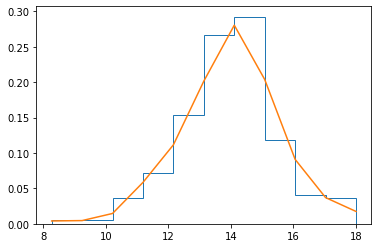

In [83]:
density = stats.gaussian_kde(kin1["ReH"])

n, x, _ = plt.hist(kin1["ReH"], 
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()

## ReE

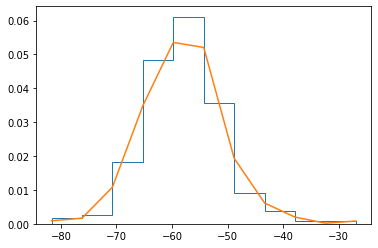

In [84]:
density = stats.gaussian_kde(kin1["ReE"])

n, x, _ = plt.hist(kin1["ReE"], 
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()

## ReHtilde

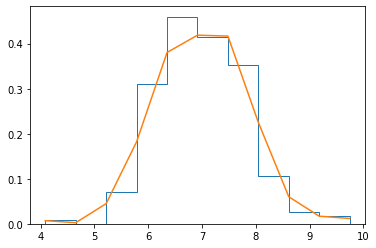

In [85]:
density = stats.gaussian_kde(kin1["ReHtilde"])

n, x, _ = plt.hist(kin1["ReHtilde"], 
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()

## F at 180

In [67]:
bhdvcs = BHDVCS()

In [65]:
x = df.loc[[18], ['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]

In [70]:
x = np.array(x)

In [71]:
res = bhdvcs.TotalUUXS(x, kin1.loc[0, 'ReH'], kin1.loc[0, 'ReE'], kin1.loc[0, 'ReHtilde'])

In [76]:
res.numpy()[0]

0.05290404717936327

In [77]:
Fs = []
for i in range(200):
    Fs.append(bhdvcs.TotalUUXS(x, kin1.loc[i, 'ReH'], kin1.loc[i, 'ReE'], kin1.loc[i, 'ReHtilde']).numpy()[0])

In [79]:
Fs = np.array(Fs)

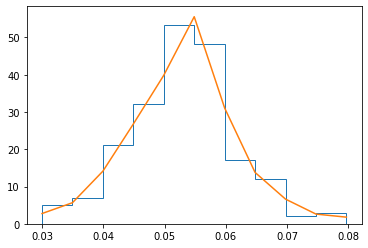

In [82]:
density = stats.gaussian_kde(Fs)

n, x, _ = plt.hist(Fs, 
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()